# Monte Carlo Simulation for Stock Price Prediction
## By Luciano Malagola

**Disclaimer:** *I am NOT a financial advisor*. I worked on this project for *educational purposes only*, and it *should not* be considered financial advice in its current state. *Always do your own research for investment decisions*.

*This tool:*
- Fetches historical stock data from Yahoo Finance based on user input for a specific company (e.g. AAPL for Apple) or currency exchange (e.g. USDEUR=X for USD/EUR).
- Evaluates the data over a selected time range (in years or months).
- Displays KPIs relevant to the study.
- Uses Linear Regression to calculate the stock's price volatility (beta -> β) relative to the market (S&P500) for the selected time range.
- Creates a Monte Carlo simulation to predict future stock prices based on historical data.
- Presents results over a horizon of 7 days.

*Python libraries used:*
- _**pandas**_ for data manipulation.
- _**numpy**_ for numerical calculations.
- _**matplotlib**_ for plotting graphs.
- _**yfinance**_ to fetch stock data.
- _**relativedelta**_ to manipulate date ranges.
- _**sklearn.linear_model**_ to calculate the stock's beta (β) relative to the market using Linear Regression.


#### **Cell 1:** Imports the required libraries.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import re

#### **Cell 2:** Defines the function `ask_abr()`. Prompts and validates de stock's ticker symbol / abbreviation input.

In [2]:
def ask_abr():
    while True:
        # Request Ticker Symbol / Abbreviation
        company = input("Input the Ticker Symbol / abbreviation (e.g. AAPL for Apple or USDEUR=X for USD/EUR):").strip().upper()
        if re.fullmatch(r"[A-Z0-9\.\-\=\^]+", company): # Uses 're' to match ticker to a valid format.
            return company
        else:
            print("Invalid Ticker Symbol, please try again (only A-Z, 0-9, '.', '-', '=', '^').") # Input error handling

company = ask_abr()

Input the Ticker Symbol / abbreviation (e.g. AAPL for Apple or USDEUR=X for USD/EUR): AAPL


#### **Cell 3:** Downloads historical stock data of the last 20 years. Handles errors if the ticker symbol / abbreviation is *invalid*.

In [3]:
# Data download (Gets the stock information of the last 20 years. If the stock is younger than 20 years, gets all the available data)
end_date = datetime.today()
start_date = end_date - relativedelta(years=20)
print(f"\nDownloading data for {company} from {start_date.date()} to {end_date.date()}...\n")
try:
    data = yf.download(company, start=start_date, end=end_date, auto_adjust=True)
except Exception as e:
    print(f"Error downloading data: {e}.")
    exit()

# Checks if data was downloaded
if data.empty:
    print("No data found for this case study or the ticker symbol is incorrect.")
    exit()
else:
    # Finds the earliest date in the data
    first_date = data.index.min()
    last_date = data.index.max()
    years_available = (last_date - first_date).days // 365
    months_available = (last_date.year - first_date.year) * 12 + (last_date.month - first_date.month)

[*********************100%***********************]  1 of 1 completed


#### **Cell 4:** Defines the function `ask_period_type_and_amount()`. Calculates available historical range, prompts for a period in **_years_** or **_months_**, and filters the dataset accordingly.

In [4]:
def ask_period_type_and_amount(years_available, months_available):
    while True:
        period_type = input(f"Do you want to use years or months for the study period? (Enter 'Y' for years or 'M' for months):").strip().upper()
        if period_type in ('YEARS', 'YEAR', 'Y'):
            while True:
                amount_input = input(f"How many years do you want to use for the study? (1 to {years_available}):").strip().upper()
                try:
                    amount = int(amount_input)
                    if 1 <= amount <= years_available:
                        return 'YEARS', amount
                    else:
                        print(f"Please enter a number between 1 and {years_available}.")
                except ValueError:
                    print("Please enter a valid integer.")
        elif period_type in ('MONTHS', 'MONTH', 'M'):
            while True:
                amount_input = input(f"How many months do you want to use for the study? (1 to {months_available}):").strip().upper()
                try:
                    amount = int(amount_input)
                    if 1 <= amount <= months_available:
                        return 'MONTHS', amount
                    else:
                        print(f"Please enter a number between 1 and {months_available}.")
                except ValueError:
                    print("Please enter a valid integer.")
        else:
            print("Invalid input. Please enter 'Y' for years or 'M' for months")

print(f"\n{company} has historical data from {first_date.date()} to {last_date.date()} ({years_available} full years, {months_available} full months available).\n")

period_type, amount = ask_period_type_and_amount(years_available, months_available)

print(f"\nYou have selected {amount} {period_type} to study")

# Calculates the start date
if period_type == 'YEARS':
    study_start_date = last_date - relativedelta(years=amount)
else:
    study_start_date = last_date - relativedelta(months=amount)
data = data[data.index >= study_start_date]


AAPL has historical data from 2005-09-01 to 2025-08-29 (20 full years, 239 full months available).



Do you want to use years or months for the study period? (Enter 'Y' for years or 'M' for months): Y
How many years do you want to use for the study? (1 to 20): 5



You have selected 5 YEARS to study


#### **Cell 5:** Previews the filtered data by showing the five first and last rows, as well as its dimensions.

In [5]:
print("\nDownloaded data:\n")
print(f"First 5 rows:\n\n{data.head()}\n")  # Shows first 5 rows
print(f"Last 5 rows:\n\n{data.tail()}\n")   # Shows last 5 rows
print(f"Data contains {data.shape[0]} rows and {data.shape[1]} columns.")  # Show data dimensions


Downloaded data:

First 5 rows:

Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2020-08-31  125.519485  127.426019  122.562430  124.099326  225702700
2020-09-01  130.519272  131.122367  126.968858  129.138014  151948100
2020-09-02  127.815102  134.215586  123.535150  133.836227  200119000
2020-09-03  117.582138  125.324972  117.212508  123.447633  257599600
2020-09-04  117.659966  120.325211  107.864696  116.794247  332607200

Last 5 rows:

Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2025-08-25  227.160004  229.300003  226.229996  226.479996  30983100
2025-08-26  229.309998  229.490005  224.690002  226.869995  54575100
2025-08-27  230.490005  230.899994  228.259995

#### **Cell 6:** Calculates and displays KPIs such as max, min, mean, std, and last close, computes daily returns, and plots the closing price chart.


KPIs over selected period 2020-08-29 to 2025-08-29

'Close' Price Statistics:
  • Historic max: 258.1037
  • Historic min: 103.9252
  • Mean: 169.7714
  • Standard deviation: 36.2855
  • Last price: 232.1400

Daily Returns Statistics:
  • Daily mean return (μ): 0.0007
  • Daily standard deviation (σ): 0.0184



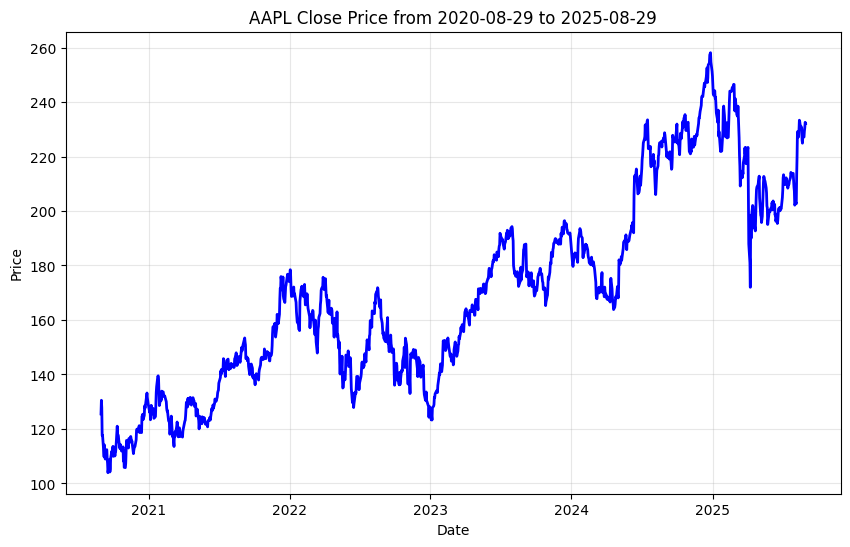

In [6]:
close = data[('Close', company)]

if close is not None:
    # Important metrics
    print(f"\nKPIs over selected period {study_start_date.date()} to {last_date.date()}")
    
    print("\n'Close' Price Statistics:")
    print(f"  • Historic max: {close.max():.4f}")
    print(f"  • Historic min: {close.min():.4f}")
    print(f"  • Mean: {close.mean():.4f}")
    print(f"  • Standard deviation: {close.std():.4f}")
    print(f"  • Last price: {close.iloc[-1]:.4f}")

    # Daily mean return and standard deviation
    daily_returns = close.pct_change().dropna()
    mu = daily_returns.mean()
    sigma = daily_returns.std()

    print("\nDaily Returns Statistics:")
    print(f"  • Daily mean return (μ): {mu:.4f}")
    print(f"  • Daily standard deviation (σ): {sigma:.4f}\n")

    # Graph of 'Close' prices using Matplotlib
    plt.figure(figsize=(10, 6))
    plt.plot(close, label='Close Price', color='blue', linewidth=2)
    plt.title(f"{company} Close Price from {study_start_date.date()} to {last_date.date()}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True, alpha=0.3)
    plt.show()

else:
    print("Cannot perform the analysis without 'Close' price data.")
    exit()

#### **Cell 7:** Calculates the stock's price volatility / beta (β) relative to the market. Downloads S&P 500 data, calculates the beta and its *Coefficient of Determination* (R²) through linear regression, and plots the relationship for visual interpretation.

[*********************100%***********************]  1 of 1 completed


Estimated beta (β) vs S&P 500: 1.2846 (R² = 0.5824)



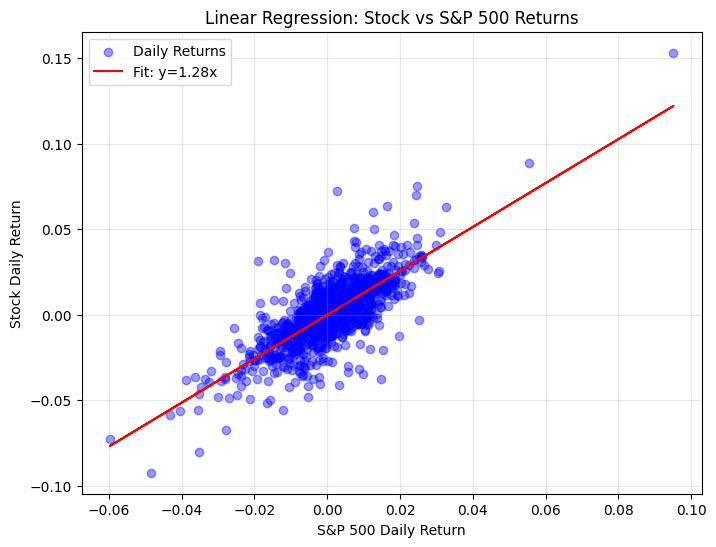

In [7]:
from sklearn.linear_model import LinearRegression

sp500 = yf.download("^GSPC", start=first_date, end=last_date, auto_adjust=True)
if not sp500.empty:
    sp500_close = sp500['Close']
    sp500_returns = sp500_close.pct_change().dropna()
    aligned = pd.concat([daily_returns, sp500_returns], axis=1, join='inner').dropna()
    aligned.columns = ['stock', 'sp500']

    if len(aligned) > 1:
        X = aligned['sp500'].values.reshape(-1, 1)
        y = aligned['stock'].values
        model = LinearRegression().fit(X, y)
        beta = model.coef_[0]
        r2 = model.score(X, y)
        print(f"\nEstimated beta (β) vs S&P 500: {beta:.4f} (R² = {r2:.4f})\n")
        
        # Plot regression
        plt.figure(figsize=(8,6))
        plt.scatter(X, y, alpha=0.4, color='blue', label='Daily Returns')
        plt.plot(X, model.predict(X), color='red', label=f'Fit: y={beta:.2f}x')
        plt.xlabel('S&P 500 Daily Return')
        plt.ylabel('Stock Daily Return')
        plt.title('Linear Regression: Stock vs S&P 500 Returns')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
    else:
        print("\nEstimated beta (β) vs S&P 500: N/A\n")
else:
    print("\nEstimated beta (β) vs S&P 500: N/A\n")

#### **Cell 8:** Defines the function `monte_carlo_simulation()` that runs the Monte Carlo simulation (100,000 simulations - 7 days), then plots the resulting paths.

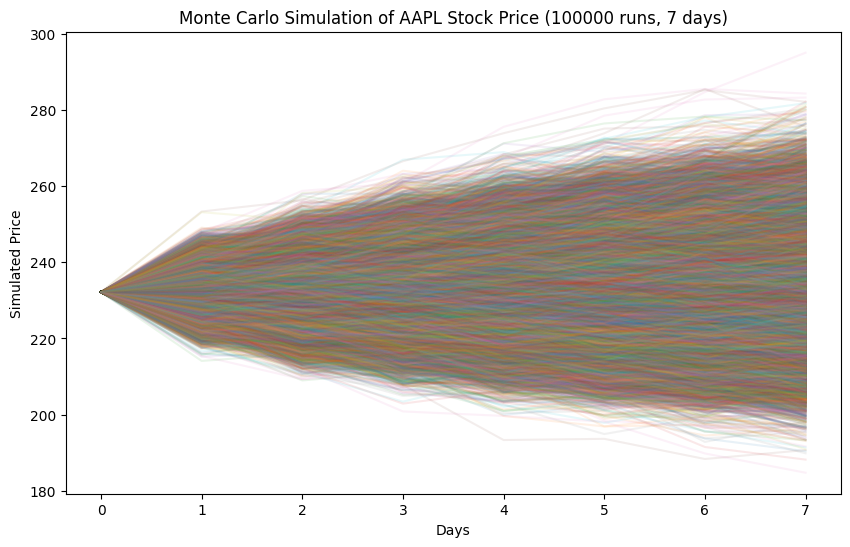

In [8]:
def monte_carlo_simulation(close, num_simulations, num_days):
    # Calculate daily returns
    daily_returns = close.pct_change().dropna()
    mu = daily_returns.mean()
    sigma = daily_returns.std()
    last_price = close.iloc[-1]

    # Simulation matrix
    simulations = np.zeros((num_days, num_simulations))

    for sim in range(num_simulations):
        price = last_price
        simulations[0, sim] = price  # Set day 0 to last closing price
        for day in range(1, num_days):
            price = price * np.exp((mu - 0.5 * sigma**2) + sigma * np.random.normal())
            simulations[day, sim] = price

    return simulations

# Monte Carlo simulation
num_simulations = 100000  # Number of simulated price paths
num_days = 8            # Number of days to simulate
simulations = monte_carlo_simulation(close, num_simulations, num_days)

# Plots the simulation results using Matplotlib
plt.figure(figsize=(10,6))
for i in range(num_simulations):
    plt.plot(simulations[:, i], alpha=0.1)
plt.title(f"Monte Carlo Simulation of {company} Stock Price ({num_simulations} runs, {num_days-1} days)")
plt.xlabel("Days")
plt.ylabel("Simulated Price")
plt.show()

#### **Cell 9:** Summarizes simulation results by showing 95% Confidence Intervals, mean, and median prices for each simulated day.

In [9]:
# Calculates and prints the 95% confidence intervals, mean and median for each day
print(f"\n95% confidence intervals, mean and median for each of the {num_days-1} days:")
for day in range(num_days):
    day_prices = simulations[day, :]
    conf_int = np.percentile(day_prices, [2.5, 97.5])
    if day == 0:
        print(f"Day  0 (Last Close): ${conf_int[0]:.4f}")
    else:
        print(f"Day {day:2d}: Interval = [${conf_int[0]:.4f} - ${conf_int[1]:.4f}] | Mean = ${np.mean(day_prices):.4f} | Median = ${np.median(day_prices):.4f}")


95% confidence intervals, mean and median for each of the 7 days:
Day  0 (Last Close): $232.1400
Day  1: Interval = [$223.9939 - $240.7646] | Mean = $232.2889 | Median = $232.2653
Day  2: Interval = [$220.7386 - $244.5342] | Mean = $232.4201 | Median = $232.3579
Day  3: Interval = [$218.3482 - $247.4282] | Mean = $232.5606 | Median = $232.4974
Day  4: Interval = [$216.3841 - $250.0419] | Mean = $232.7350 | Median = $232.6030
Day  5: Interval = [$214.6447 - $252.3210] | Mean = $232.8723 | Median = $232.6815
Day  6: Interval = [$213.1010 - $254.4193] | Mean = $233.0326 | Median = $232.7861
Day  7: Interval = [$211.7482 - $256.4138] | Mean = $233.1877 | Median = $232.9233


#### **Cell 10:** Plots the mean and median simulated prices over time for comparison.

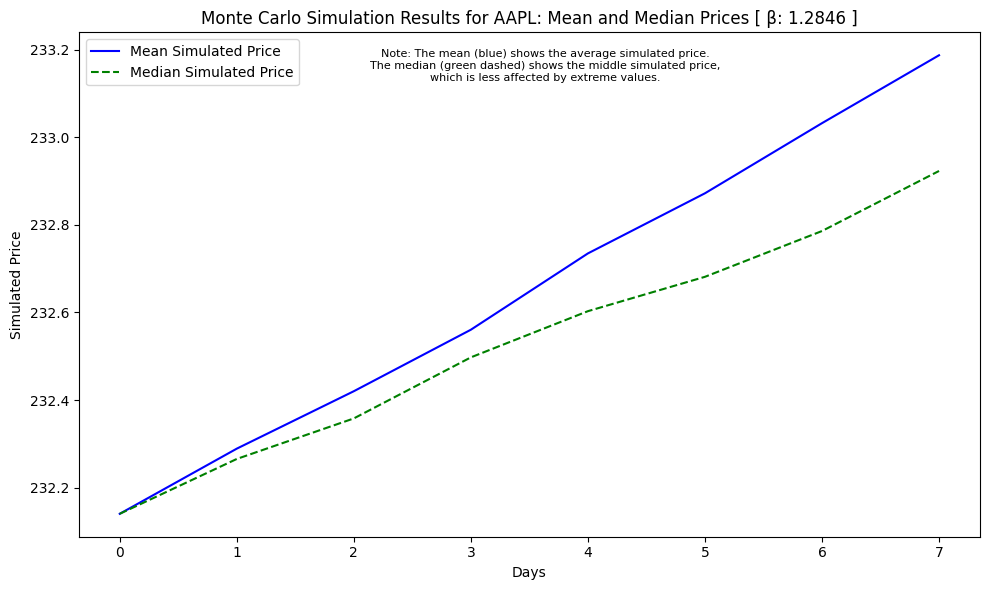

In [10]:
# Plots the Mean and Median Prices using Matplotlib
mean_prices = np.mean(simulations, axis=1)
median_prices = np.median(simulations, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(mean_prices, color='blue', label='Mean Simulated Price')
plt.plot(median_prices, color='green', linestyle='--', label='Median Simulated Price')
plt.title(f"Monte Carlo Simulation Results for {company}: Mean and Median Prices [ β: {beta:.4f} ]")
plt.xlabel("Days")
plt.ylabel("Simulated Price")
plt.legend()
plt.figtext(0.55, 0.86, "Note: The mean (blue) shows the average simulated price.\nThe median (green dashed) shows the middle simulated price,\nwhich is less affected by extreme values.", wrap=True, horizontalalignment='center', fontsize=8)
plt.tight_layout()
plt.show()

### Why Consider Beta (β) in the Analysis?

The **beta (β)** measures a stock’s volatility relative to the market (e.g., S&P 500) and helps interpret the results of the Monte Carlo simulations. Knowing the beta allows for a better understanding of price behavior and whether the _**mean**_ or _**median**_ is the most reliable indicator in the simulation results.

**Interpreting Beta Values:** 
- **Beta > 1.0:** The stock is more volatile than the market; its price swings more sharply.  
- **Beta = 1.0:** The stock moves in line with the overall market.  
- **Beta < 1.0:** The stock is less volatile than the market.  
- **Negative Beta:** The stock tends to move in the opposite direction of the market.

**When to Use the _Mean_ or _Median_:**
- **Mean when β << 1:** Best for low-volatility stocks with stable, symmetric price patterns.  
- **Mean & Median when β ≈ 1:** Both are useful; the mean shows the average trend, while the median reduces the impact of outliers.  
- **Median when β >> 1:** Better for high-volatility stocks where extreme price swings can skew the mean.
